In [2]:
import os
import random
import shutil

In [3]:
from tensorflow.python.framework.config import list_physical_devices, set_memory_growth

physical_devices = list_physical_devices("GPU")
print(f"Number of GPUs available: {len(physical_devices)}")

if len(physical_devices) > 0:
    set_memory_growth(physical_devices[0], True)

MUSHROOMS_DIR = "/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms"

SET_DIR = "files"
SET_TYPES = {
    "train": 0.75,
    "valid": 0.15,
    "test": 0.1,
}

Number of GPUs available: 1


In [4]:
os.mkdir(SET_DIR)

for set in SET_TYPES.keys():
    if set not in os.listdir(SET_DIR):
        os.mkdir(os.path.join(SET_DIR, set))

In [5]:
from struct import unpack
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image",
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, "rb") as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data)==0:
                break

In [6]:
for mushroom_type in filter(
        lambda entity_name:
            os.path.isdir(os.path.join(MUSHROOMS_DIR, entity_name)) and not entity_name.startswith("."),
        os.listdir(MUSHROOMS_DIR)
):
    print(mushroom_type)

    mushroom_type_path = os.path.join(MUSHROOMS_DIR, mushroom_type)
    mushroom_images = os.listdir(mushroom_type_path)
    random.shuffle(mushroom_images)

    images_count = len(mushroom_images)
    from_idx = 0
    to_idx = 0

    for type, size in SET_TYPES.items():
        size_set = int(images_count * size)
        print(f"{type.capitalize()} set contains {size_set} pictures")

        set_subfolder = os.path.join(SET_DIR, type, mushroom_type)
        os.mkdir(set_subfolder)
        to_idx += size_set

        for mushroom_image in mushroom_images[from_idx:to_idx]:
            full_image_path = os.path.join(mushroom_type_path, mushroom_image)
            tmp_img = JPEG(full_image_path)
            try:
                tmp_img.decode()
            except Exception as e:
                pass
            else:
              shutil.copyfile(full_image_path, f"{set_subfolder}/{mushroom_image}")

        from_idx = to_idx
    print()

Entoloma
Train set contains 273 pictures
Valid set contains 54 pictures
Test set contains 36 pictures

Agaricus
Train set contains 264 pictures
Valid set contains 52 pictures
Test set contains 35 pictures

Russula
Train set contains 861 pictures
Valid set contains 172 pictures
Test set contains 114 pictures

Hygrocybe
Train set contains 237 pictures
Valid set contains 47 pictures
Test set contains 31 pictures

Boletus
Train set contains 804 pictures
Valid set contains 160 pictures
Test set contains 107 pictures

Suillus
Train set contains 233 pictures
Valid set contains 46 pictures
Test set contains 31 pictures

Lactarius
Train set contains 1172 pictures
Valid set contains 234 pictures
Test set contains 156 pictures

Cortinarius
Train set contains 627 pictures
Valid set contains 125 pictures
Test set contains 83 pictures

Amanita
Train set contains 562 pictures
Valid set contains 112 pictures
Test set contains 75 pictures



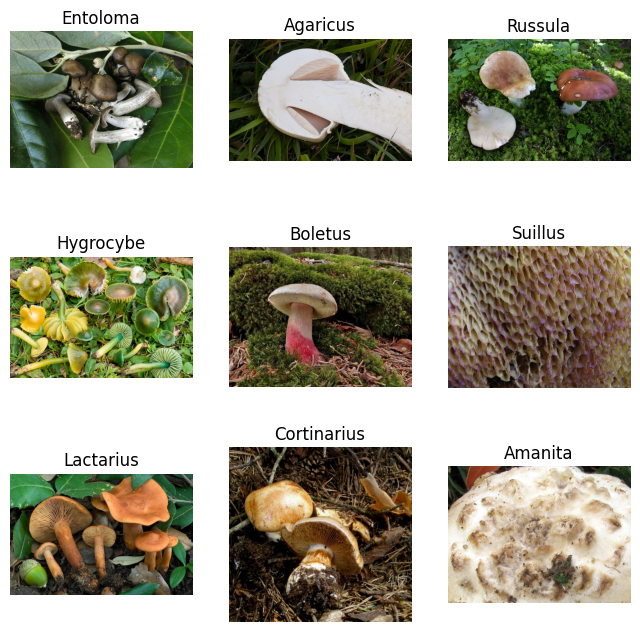

In [7]:
from matplotlib import pyplot as plt
from PIL import Image

train_path = os.path.join(SET_DIR, "train")
fig = plt.figure(figsize=(8,8))

for i, mushroom_example in enumerate(os.listdir(train_path), start=1):
    train_type_path = os.path.join(train_path, mushroom_example)
    example = os.path.join(train_type_path, os.listdir(train_type_path)[0])
    with Image.open(example) as example:
        plt.subplot(3,3, i)
        plt.imshow(example)
        plt.title(mushroom_example)
        plt.axis("off")

fig.show()

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.efficientnet import preprocess_input

IMAGE_SIZE = (299, 299)

def efficientnet_preprocess(image, label):
    image = preprocess_input(image)
    return image, label

train_df = image_dataset_from_directory(
    directory=os.path.join(SET_DIR, "train"),
    image_size=IMAGE_SIZE,
    label_mode="categorical",
    batch_size=64,
)
p_train_df = train_df.map(efficientnet_preprocess)

test_df = image_dataset_from_directory(
    directory=os.path.join(SET_DIR, "test"),
    image_size=IMAGE_SIZE,
    label_mode="categorical",
    batch_size=64,
)
p_test_df = test_df.map(efficientnet_preprocess)

valid_df = image_dataset_from_directory(
    directory=os.path.join(SET_DIR, "valid"),
    image_size=IMAGE_SIZE,
    label_mode="categorical",
    batch_size=64,
)
p_valid_df = valid_df.map(efficientnet_preprocess)

Found 5030 files belonging to 9 classes.
Found 668 files belonging to 9 classes.
Found 1002 files belonging to 9 classes.


In [9]:
from tensorflow.keras.applications import EfficientNetB7

model = EfficientNetB7(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMAGE_SIZE, 3),
    pooling="avg"
)

model.summary()

258076736/258076736 [==============================] - 9s 0us/step
Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 299, 299, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 299, 299, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Resc

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

additional_model = Sequential(
    [
        model,
        Dense(len(train_df.class_names), activation="softmax"),
    ]
)

additional_model.layers[0].trainable = False


additional_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

additional_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 dense (Dense)               (None, 9)                 23049     
                                                                 
Total params: 64120736 (244.60 MB)
Trainable params: 23049 (90.04 KB)
Non-trainable params: 64097687 (244.51 MB)
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True,
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    mode="max",
    cooldown=2,
    patience=2,
)

In [12]:
history = additional_model.fit(
        p_train_df,
        verbose=2,
        callbacks=[reduce_lr_cb, early_stop_cb],
        validation_data=p_valid_df,
        epochs=100,
)

Epoch 1/100
79/79 - 190s - loss: 1.3956 - accuracy: 0.5292 - val_loss: 1.0955 - val_accuracy: 0.6347 - lr: 0.0010 - 190s/epoch - 2s/step
Epoch 2/100
79/79 - 153s - loss: 1.0019 - accuracy: 0.6799 - val_loss: 0.9218 - val_accuracy: 0.7036 - lr: 0.0010 - 153s/epoch - 2s/step
Epoch 3/100
79/79 - 137s - loss: 0.8628 - accuracy: 0.7268 - val_loss: 0.8320 - val_accuracy: 0.7246 - lr: 0.0010 - 137s/epoch - 2s/step
Epoch 4/100
79/79 - 137s - loss: 0.7730 - accuracy: 0.7577 - val_loss: 0.7682 - val_accuracy: 0.7505 - lr: 0.0010 - 137s/epoch - 2s/step
Epoch 5/100
79/79 - 154s - loss: 0.7200 - accuracy: 0.7793 - val_loss: 0.7233 - val_accuracy: 0.7525 - lr: 0.0010 - 154s/epoch - 2s/step
Epoch 6/100
79/79 - 136s - loss: 0.6659 - accuracy: 0.7934 - val_loss: 0.6941 - val_accuracy: 0.7715 - lr: 0.0010 - 136s/epoch - 2s/step
Epoch 7/100
79/79 - 136s - loss: 0.6360 - accuracy: 0.7994 - val_loss: 0.6795 - val_accuracy: 0.7685 - lr: 0.0010 - 136s/epoch - 2s/step
Epoch 8/100
79/79 - 136s - loss: 0.6051 -

In [13]:
loss, accuracy = additional_model.evaluate(
    p_test_df,
    steps=11,
    verbose=2,
)
print("Test images model performance")
print(f"Accuracy = {accuracy}, Loss = {loss}")

11/11 - 20s - loss: 0.5052 - accuracy: 0.8263 - 20s/epoch - 2s/step
Test images model performance
Accuracy = 0.826347291469574, Loss = 0.5051620006561279


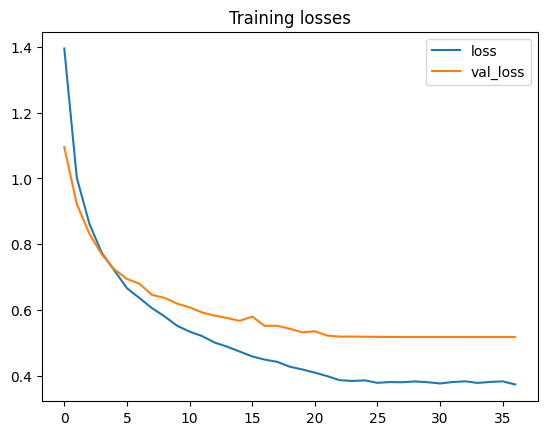

In [14]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ["loss", "val_loss"]].plot()
plt.title("Training losses")
plt.show()

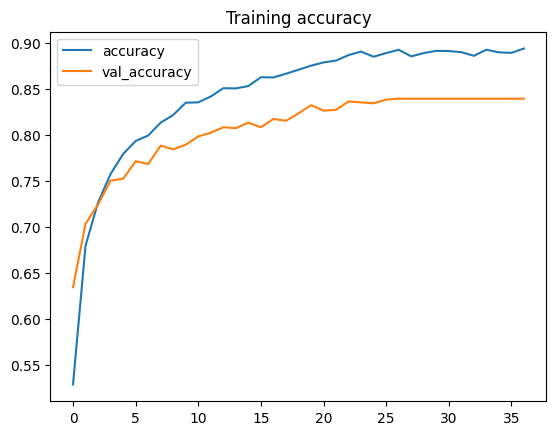

In [15]:
history_frame.loc[:, ["accuracy", "val_accuracy"]].plot()
plt.title("Training accuracy")
plt.show()

In [16]:
additional_model.save("mushroom_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
import pickle

with open("mushroom_classes.pkl", "wb") as f:
  pickle.dump(train_df.class_names, f)